In [61]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # limits OpenMP to use only 1 CPU core.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for a nicer scatter plot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [46]:
# load dataset
df = pd.read_csv("Mall_Customers.csv")
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [47]:
# get some idea about the dataset
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [48]:
#in here, CustomerID is Just an identifier.So, not useful for clustering.can be dropped
#Gender is Categorical.So, Needs encoding
#others are numerical.

In [49]:
# Data preprocessing

# Remove duplicates
dataset.drop_duplicates(inplace=True)

# Drop CustomerID column
df_clean = dataset.drop('CustomerID', axis=1)

# Handle missing values
dataset.fillna(dataset.mean(numeric_only=True), inplace=True)

In [50]:
# Encode 'Gender' column (Male=0, Female=1)
le = LabelEncoder()
df_clean['Gender'] = le.fit_transform(df_clean['Gender'])

# Check cleaned dataset
print(df_clean.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40


In [51]:
# Feature scaling
scaler = StandardScaler() # Initialize the scaler
X_scaled = scaler.fit_transform(df_clean) # Scale all features

print(X_scaled[:5])
df.head()

[[ 1.12815215 -1.42456879 -1.73899919 -0.43480148]
 [ 1.12815215 -1.28103541 -1.73899919  1.19570407]
 [-0.88640526 -1.3528021  -1.70082976 -1.71591298]
 [-0.88640526 -1.13750203 -1.70082976  1.04041783]
 [-0.88640526 -0.56336851 -1.66266033 -0.39597992]]


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [52]:
#since this is unsupervised ML, we dont have to split data.

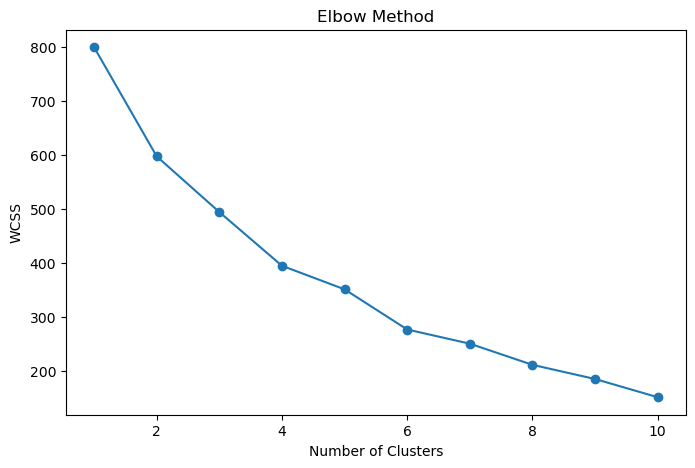

In [68]:
wcss = [] # Within-cluster sum of squares

for i in range(1,11): # Test 1-10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot WCSS to find the elbow
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [74]:
kmeans = KMeans(n_clusters = 5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to df
df_clean['Cluster'] = clusters

In [75]:
# Check cluster assignments
print(df_clean['Cluster'].value_counts())

Cluster
0    51
3    49
2    42
4    38
1    20
Name: count, dtype: int64


In [76]:
#Calculate silhouette score
score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", score)
# if score > 0.5 (Strong clustering)
# if score 0.25–0.5 (Reasonable)
# if scoore < 0.25 (Poor clustering)

Silhouette Score: 0.27191023466188324


In [77]:
# Davies–Bouldin Score (lower is better)
db_score = davies_bouldin_score(X_scaled, clusters)
print("Davies-Bouldin Score:", db_score)

Davies-Bouldin Score: 1.1810914524061709


In [78]:
# Initialize PCA to reduce features to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


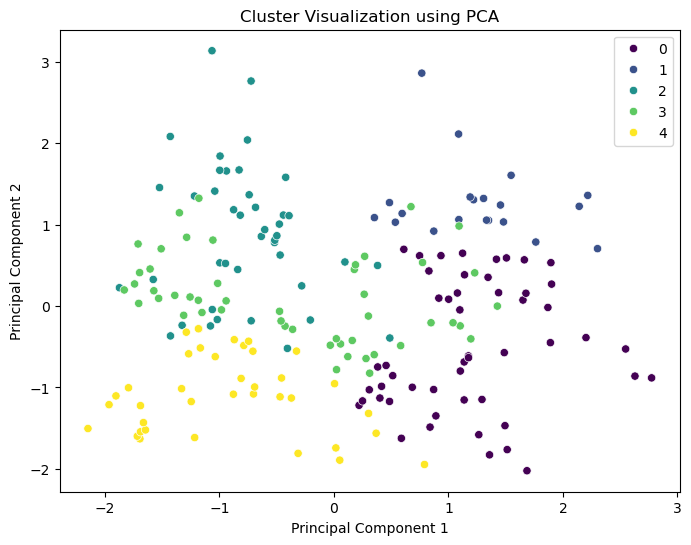

In [79]:
plt.figure(figsize = (8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=clusters, palette='viridis')
#plotting
plt.title("Cluster Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [80]:
#DBSCAN Clustering
dbscan = DBSCAN(
    eps = 0.5, # max distance between two samples to be considered as neighbors
    min_samples = 5 #minimum no of points needed to form a cluster
)

db_clusters = dbscan.fit_predict(X_scaled) #DBSCAN labels -1 for noise

df['DBSCAN_Cluster'] = db_clusters


In [81]:
#Now analyze the clusters formed by DBSCAN

# Convert the DBSCAN cluster labels into a set
unique_clusters = set(db_clusters)

print("Clusters found:", unique_clusters)
print("Number of clusters (excluding noise):",
      len(unique_clusters) - (1 if -1 in unique_clusters else 0))


Clusters found: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(-1)}
Number of clusters (excluding noise): 9


In [82]:
#Calculate silhouette score for DBSCAN
mask = db_clusters != -1  #remove noise points

sil_score_dbscan = silhouette_score(
    X_scaled[mask],
    db_clusters[mask]
)

print("DBSCAN Silhouette Score:", sil_score_dbscan)


DBSCAN Silhouette Score: 0.5395188047455788


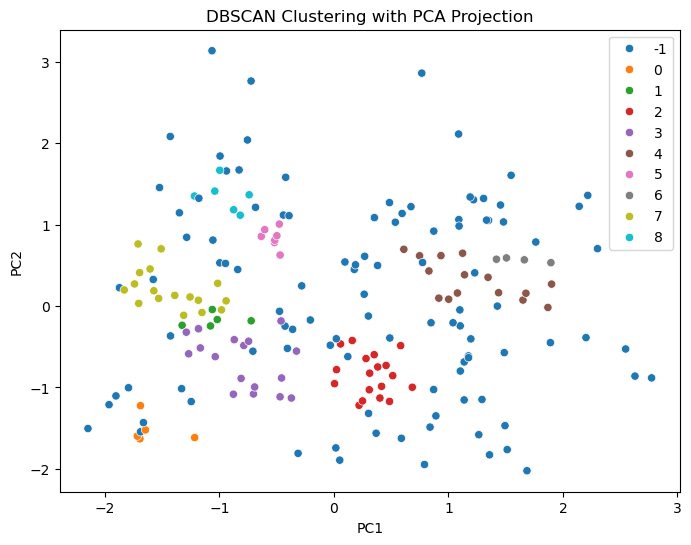

In [83]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=db_clusters,
    palette='tab10'
)
plt.title("DBSCAN Clustering with PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [84]:
print("K-Means Silhouette Score:", score)
print("Davies-Bouldin Score:", db_score)
print("DBSCAN Silhouette Score:", sil_score_dbscan)


K-Means Silhouette Score: 0.27191023466188324
Davies-Bouldin Score: 1.1810914524061709
DBSCAN Silhouette Score: 0.5395188047455788
